## Rationalizacja przyjęcia klasyfikacji "K najbliższych sąsiadów"

### Podstawowe zalety wyboru metody K najbliższych sąsiadów (KNN):

1. **Prostota implementacji**: K-NN to algorytm bazujący na prostym założeniu: obiekty podobne do siebie znajdują się blisko w przestrzeni cech. Nie wymaga on złożonego modelowania matematycznego ani obliczeń wstępnych, co czyni go idealnym do szybkiego prototypowania i testowania.

2. **Wysoka dokładność w specyficznych warunkach**: K-NN może osiągać wysoką dokładność w aplikacjach, gdzie prognozy nie są wymagane często, ale ważna jest ich dokładność. Jest to szczególnie przydatne w przypadkach, gdzie dane są dobrze oznakowane i wolne od szumów, co jest stanem naszych danych.

3. **Skuteczność dla złożonych wzorców**: Algorytm K-NN jest wyjątkowo dobry w rozpoznawaniu skomplikowanych wzorców w danych, takich jak wielowymiarowe cechy chemiczne wina, które mogą być subtelnie powiązane z jakością wina na dyskretnej skali od 1 do 10.

4. **Brak założeń na temat danych**: W przeciwieństwie do innych technik klasyfikacyjnych, K-NN nie wymaga założeń statystycznych dotyczących rozkładu danych. Jest to korzystne w przypadku rzeczywistych, często nieskonsolidowanych zestawów danych, co zwiększa jego uniwersalność i adaptacyjność do różnorodnych zbiorów danych.

5. **Elastyczność w wyborze metryki**: K-NN pozwala na łatwą zmianę metryki dystansu (np. euklidesowa, Manhattan), co umożliwia dostosowanie algorytmu do specyfiki danych wina, które mogą różnić się skalą i naturą. Ta elastyczność jest kluczowa, gdy dane różnią się w zakresie ich skali lub wymagają niestandardowego traktowania dystansu.



# Zaimportowanie bibliotek oraz danych z plików CSV (przekształcenie ich w dataframy i wizualizacja klastrów)

In [10]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, label_binarize

In [11]:
# Wczytanie danych z pliku CSV (X_test.csv, X_train.csv, y_test.csv, y_train.csv)
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')
# Wyswietl informacje o danych
print("X_train shape: ", X_train.shape, "y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape, "y_test shape: ", y_test.shape)


X_train shape:  (1052, 5) y_train shape:  (1052, 1)
X_test shape:  (451, 5) y_test shape:  (451, 1)


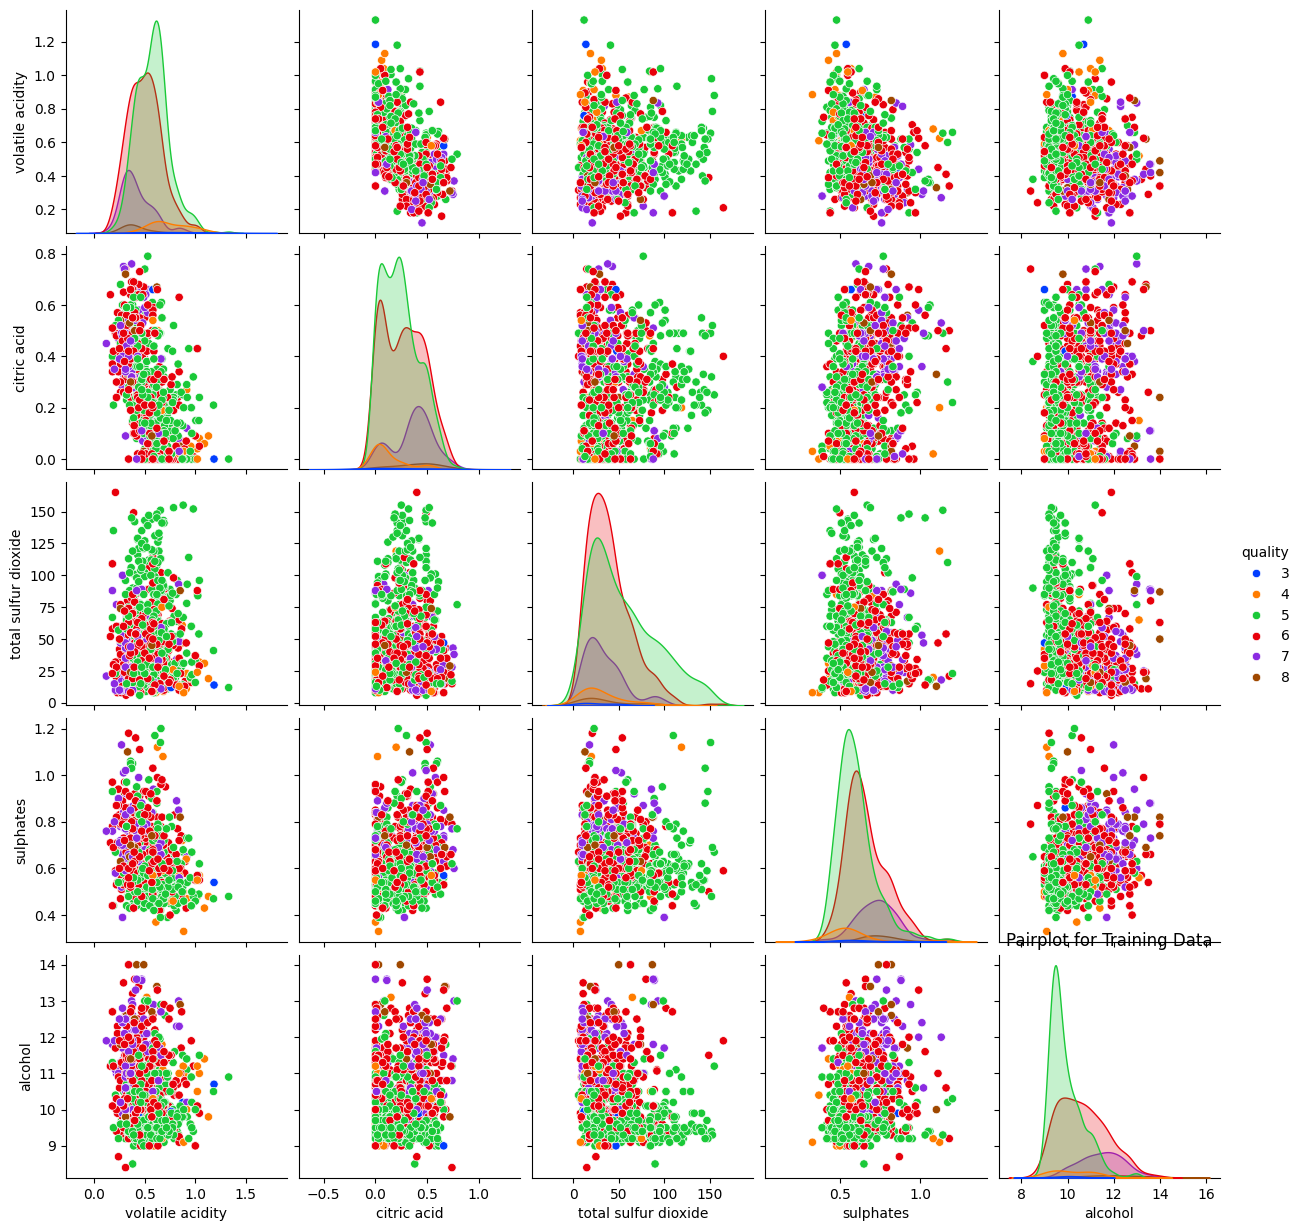

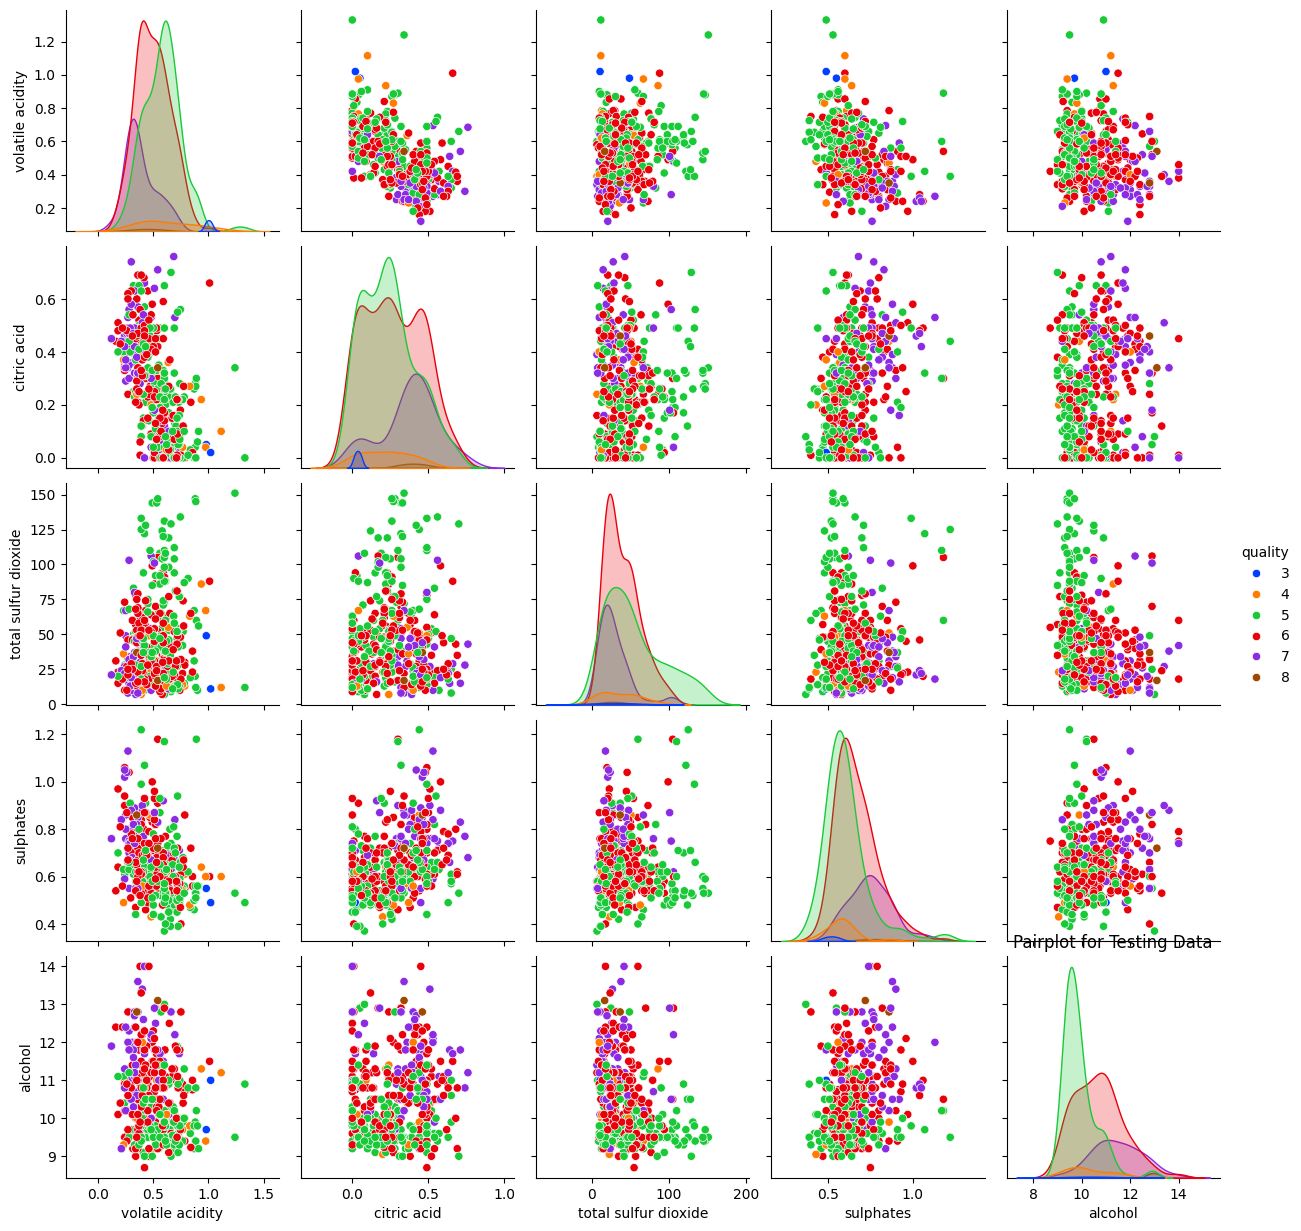

In [12]:
# Tymczasowe połączenie danych treningowych i testowych
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

# Stworzenie wykresów dla danych treningowych (pairplot - wykresy punktowe)
sns.pairplot(train_data, hue='quality', palette='bright')
plt.title('Pairplot for Training Data')
plt.show()

# Stworzenie wykresów dla danych testowych (powinno być podobne do danych treningowych)
sns.pairplot(test_data, hue='quality', palette='bright')
plt.title('Pairplot for Testing Data')
plt.show()


# Stworzenie modelu KNN oraz jego optymalizacja

Funckja scale_and_train: skaluje dane treningowe i testowe oraz trenuje klasyfikator K-Nearest Neighbors na przeskalowanych danych treningowych.
    
    Parametry:
        X_train (array): Cechy danych treningowych.
        X_test (array): Cechy danych testowych.
        y_train (array): Etykiety danych treningowych.
    
    Zwraca:
        tuple: Krotka zawierająca wytrenowany model KNN oraz przeskalowane dane treningowe i testowe.

In [13]:
def scale_and_train(X_train, X_test, y_train):
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)  # Dopasuj i przetransformuj dane treningowe
    X_test_scaled = scaler.transform(X_test)  # Przetransformuj dane testowe przy użyciu tego samego skalera
    knn = KNeighborsClassifier()  # Inicjalizuj klasyfikator KNN
    knn.fit(X_train_scaled, y_train.ravel())  # Trenuj model KNN
    return knn, X_train_scaled, X_test_scaled


Funckja evaluate_model: Ocenia wytrenowany model K-Nearest Neighbors przy użyciu przeskalowanych danych testowych.
    
    Parametry:
        knn (KNeighborsClassifier): Wytrenowany model KNN.
        X_test_scaled (array): Przeskalowane cechy danych testowych.
        y_test (array): Rzeczywiste etykiety danych testowych.
    
    Zwraca:
        tuple: Krotka zawierająca macierz pomyłek i predykcje.
    """

In [14]:
def evaluate_model(knn, X_test_scaled, y_test):
    y_pred = knn.predict(X_test_scaled)  # Przewiduj etykiety dla danych testowych
    print("Macierz pomyłek:")
    cm = confusion_matrix(y_test, y_pred)  # Oblicz macierz pomyłek
    print(cm)
    print("\nRaport klasyfikacji:")
    print(classification_report(y_test, y_pred, zero_division=1))  # Generuj raport klasyfikacji
    print(f"Dokładność: {accuracy_score(y_test, y_pred)}\n")  # Wydrukuj dokładność modelu

Funckja grid_search_optimization: Wykonuje wyszukiwanie siatkowe w celu znalezienia optymalnej liczby sąsiadów dla KNN na podstawie walidacji krzyżowej.
    
    Parametry:
        X_train_scaled (array): Przeskalowane cechy danych treningowych.
        y_train (array): Etykiety danych treningowych.
    
    Zwraca:
        int: Optymalna liczba sąsiadów.

In [15]:
def grid_search_optimization(X_train_scaled, y_train):
    
    param_grid = {'n_neighbors': np.arange(1, 25)}  # Definiuj siatkę parametrów dla 'n_neighbors'
    knn_gscv = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)  # Ustaw wyszukiwanie siatkowe z 5-krotną walidacją krzyżową
    knn_gscv.fit(X_train_scaled, y_train.ravel())  # Wykonaj wyszukiwanie siatkowe
    return knn_gscv.best_params_['n_neighbors']  # Wydobyj najlepszą liczbę sąsiadów

Funckja train_optimized_knn: Trenuje i ocenia zoptymalizowany model KNN przy użyciu najlepszej liczby sąsiadów.
    
    Parametry:
        X_train_scaled (array): Przeskalowane cechy danych treningowych.
        y_train (array): Etykiety danych treningowych.
        X_test_scaled (array): Przeskalowane cechy danych testowych.
        y_test (array): Etykiety danych testowych.
        best_k (int): Optymalna liczba sąsiadów.

In [16]:

def train_optimized_knn(X_train_scaled, y_train, X_test_scaled, y_test, best_k):
    
    knn_optimized = KNeighborsClassifier(n_neighbors=best_k)  # Inicjalizuj klasyfikator KNN z najlepszą liczbą sąsiadów
    knn_optimized.fit(X_train_scaled, y_train.ravel())  # Trenuj zoptymalizowany model KNN
    y_pred_optimized = knn_optimized.predict(X_test_scaled)  # Przewiduj za pomocą zoptymalizowanego modelu
    print(f"Zoptymalizowana dokładność: {accuracy_score(y_test, y_pred_optimized)}")  # Wydrukuj dokładność zoptymalizowanego modelu
    print("Macierz pomyłek:")
    cm = confusion_matrix(y_test, y_pred_optimized)  # Oblicz macierz pomyłek
    print(cm)
    print("\nRaport klasyfikacji:")
    print(classification_report(y_test, y_pred_optimized, zero_division=1))  # Generuj raport klasyfikacji
    print(f"Dokładność: {accuracy_score(y_test, y_pred_optimized)}\n")  # Wydrukuj dokładność modelu
    return cm, y_pred_optimized

In [17]:
# Trenuj i oceniaj model KNN
knn, X_train_scaled, X_test_scaled = scale_and_train(X_train, X_test, y_train.values.ravel())
evaluate_model(knn, X_test_scaled, y_test.values.ravel())
best_k = grid_search_optimization(X_train_scaled, y_train.values.ravel())
cm, y_pred = train_optimized_knn(X_train_scaled, y_train.values.ravel(), X_test_scaled, y_test.values.ravel(), best_k)

Macierz pomyłek:
[[  0   1   0   1   0   0]
 [  0   1   9   6   0   0]
 [  0   5 125  43   0   0]
 [  0   1  65 107  14   0]
 [  0   0   9  40  22   0]
 [  0   0   0   0   2   0]]

Raport klasyfikacji:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         2
           4       0.12      0.06      0.08        16
           5       0.60      0.72      0.66       173
           6       0.54      0.57      0.56       187
           7       0.58      0.31      0.40        71
           8       1.00      0.00      0.00         2

    accuracy                           0.57       451
   macro avg       0.64      0.28      0.28       451
weighted avg       0.56      0.57      0.55       451

Dokładność: 0.565410199556541

Zoptymalizowana dokładność: 0.5831485587583148
Macierz pomyłek:
[[  0   1   0   1   0   0]
 [  2   1   7   5   1   0]
 [  1   3 117  50   2   0]
 [  0   2  52 105  27   1]
 [  0   0   6  25  39   1]
 [  0   0   0   1   0   1

# Macierz pomyłek (niestety tylko na razie to)

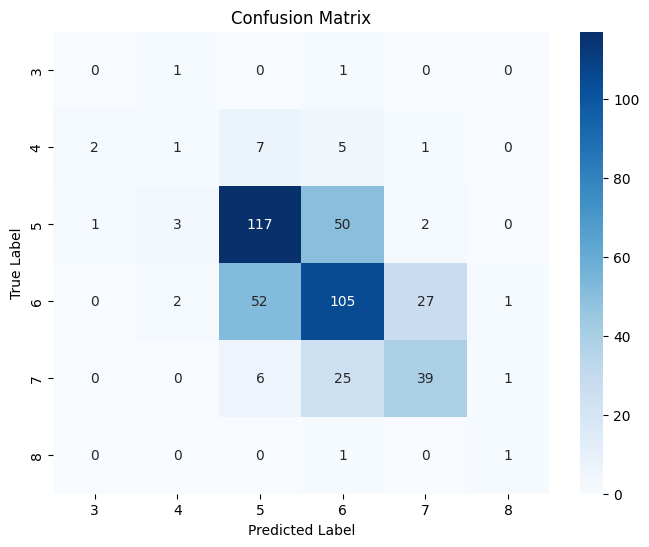

In [18]:
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

classes = [3, 4, 5, 6, 7, 8]

plot_confusion_matrix(cm, classes)

# Płacz, zgrzyt zębów i ostatecznie poddanie się

## **Analiza Podstawowa**

Analiza raportu dotyczącego wydajności modelu klasyfikacyjnego obejmuje różne aspekty oceny, takie jak **macierz pomyłek**, **dokładność**, oraz miary takie jak **precyzja**, **odzysk** i **wynik F1** dla każdej klasy.

### **Macierz Pomyłek**

Macierz pomyłek przedstawia, jak dokładnie prognozy modelu zgadzają się z rzeczywistymi etykietami. Rozmiar macierzy sugeruje, że mamy do czynienia z modelem klasyfikacji sześcioklasowej. Wartości w macierzy pokazują:

- **Klasa 3:** Model nie przewidział prawidłowo żadnego przykładu (1 fałszywie pozytywny przypadek).
- **Klasa 4:** Model prawidłowo przewidział tylko 1 z 16 przypadków.
- **Klasa 5:** Model stosunkowo dobrze radzi sobie z tą klasą, przewidując 117 na 1 przypadki.
- **Klasa 6:** Model przewidział prawidłowo 105 na 187 przypadków.
- **Klasa 7:** Model przewidział 39 na 71 przypadków, pokazując słabą wydajność.
- **Klasa 8:** Model kompletnie nie radzi sobie z tą klasą, z żadnym prawidłowo przewidzianym przypadkiem.

## **Raport Klasyfikacji**

- **Dokładność (Accuracy):** Średnio, model przewiduje prawidłowo 56.5% przypadków.
- **Zoptymalizowana dokładność:** Wskazuje na pewne ulepszenia, osiągając 58%.
- **Precyzja (Precision):** Najwyższa dla klasy 3 i 8, ale niska dla pozostałych klas, szczególnie klasy 4.
- **Odzysk (Recall):** Wysoki dla klasy 5, ale bardzo niski dla klas 3 i 8.
- **Wynik F1:** Średni dla klasy 5 i 6, ale bardzo niski dla innych, co wskazuje na słabą zrównoważoną wydajność między precyzją a odzyskiem.

## **Ocena Modelu**

Ogólna wydajność modelu jest słaba ze względu na niską precyzję i odzysk w większości klas. Wynik F1, który jest harmonijną średnią precyzji i odzysku, również pokazuje ograniczoną skuteczność modelu. Problemem jest szczególnie słaba zdolność modelu do radzenia sobie z klasyfikacją klas o mniejszej liczbie próbek (klasy 3 i 8).

## **Rekomendacje**

- **Przeanalizować rozkład danych:** Sprawdzić, czy dane są niezrównoważone i rozważyć techniki takie jak oversampling dla klas mniejszościowych.
- **Dostosowanie modelu:** Eksperymentować z różnymi parametrami modelu lub próbować innych algorytmów klasyfikacji.
- **Zastosować walidację krzyżową:** Aby lepiej ocenić model na różnych podzbiorach danych.
- **Skupienie na metrykach dla poszczególnych klas:** Zwłaszcza tam, gdzie model wykazuje słabe wyniki, aby poprawić ogólną dokładność i skuteczność modelu.

Podsumowując, model wymaga znacznych ulepszeń, zwłaszcza w obszarze precyzji i odzysku dla poszczególnych klas, aby móc być bardziej użytecznym w praktycznych zastosowaniach.
